# Create synthetic dataset

This notebook creates synthetic datasets with multiple objects and structured backgrounds.
The datasets used in the paper are saved as compressed numpy tensor. See notebooks 3 and 4.

In [1]:
import genus
from genus.cropper_uncropper import Uncropper
from genus.non_max_suppression import NonMaxSuppression
from genus.namedtuple import BB
from genus.util_vis import show_batch
from genus.util import save_obj, load_obj

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import skimage.transform
import numpy
import torch 
import torchvision
from torchvision import transforms

### Helper functions

In [14]:
# specify the parameter for combining isolated object into a multi-object dataset
default_params = {
    "MIN_OBJECT_SIZE": 20,
    "MAX_OBJECT_SIZE": 40,
    "WIDTH_RAW_IMAGE": 80,
    "HEIGHT_RAW_IMAGE": 80,
    "IoM_THRESHOLD" : 0.3
    }

def torch_dilation(img, times: int=1):
    """ Takes a 2D torch tensor and perfrom dilation, i.e. bright region extend dark regions shrink """
    img = img[None, None]
    tmp = img.flatten(start_dim=0, end_dim=-4)
    for n in range(times):
        tmp = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)(tmp)
    return tmp.view_as(img[0,0])


def make_background_grid_discrete(params, n_obj=10):
    """ Generates a grid with few different spacing and few different orientation angles """
    width_big  = params["WIDTH_RAW_IMAGE"]
    height_big = params["HEIGHT_RAW_IMAGE"]
    rotated_bg = numpy.zeros((n_obj,1,width_big,height_big))
    
    for i in range(n_obj):
        angle = 15.0 * numpy.random.randint(low=0, high=4, size=1, dtype=int)  # 0,15,30,45
        dx,dy = 10 + 5 * numpy.random.randint(low=0, high=3, size=2, dtype=int)  # 10,15,20
        template = numpy.zeros((2*width_big,2*height_big))
        template[::dx,:]=1
        template[:,::dy]=1
        tmp = skimage.transform.rotate(template, angle, resize=False, center=None, order=1, clip=True, preserve_range=True)
        rotated_bg[i,0] = tmp[width_big//2:width_big//2+width_big,height_big//2:height_big//2+height_big]
    return torch.from_numpy(rotated_bg).float()


def make_isolated_blobs(size=28, n_obj=400):
    """ Create isolated binarized blobs (1 inside and 0 outside). 
    The shape of the blob is random and obtained by random sampling of the first few fourier Harmonics """
    
    N_HARMONICS=2
    
    # Preparation. Create matrix with cos and sin
    x_mat = torch.linspace(-1.0, 1.0,steps=size).view(-1,1).expand(size,size).float()
    y_mat = x_mat.clone().permute(1,0)
    r2_mat   = (x_mat**2 + y_mat**2)
    r_mat = torch.where(r2_mat>0, r2_mat.sqrt(), torch.zeros_like(r2_mat)).clamp(min=1E-6)
    cos_theta = x_mat/r_mat
    theta_tmp = torch.acos(cos_theta)
    theta = torch.where(y_mat>0, theta_tmp, -theta_tmp)
    n = 1+torch.arange(N_HARMONICS)
    n_theta = n.view(-1,1,1) * theta 
    cos_n_theta = torch.cos(n_theta)
    sin_n_theta = torch.sin(n_theta)
    
    # Compute: r(theta) = 1 + sum_n [ a_n cos(n*theta) + b_n sin(n*theta)]
    a = 1E-1 * torch.randn((n_obj, N_HARMONICS,1,1))
    b = 1E-1 * torch.randn((n_obj, N_HARMONICS,1,1))
    rf = 0.8 + (a*cos_n_theta + b*sin_n_theta).sum(dim=-3)  # this is 

    # compute the blobs
    d2 = (r_mat / rf).pow(2)
    blobs = torch.exp(-d2)*(d2<1.0).float()
    fake_labels = torch.arange(n_obj)+1
    return blobs.unsqueeze(-3), fake_labels


def create_dataset(params, dataset_single_objects, goal_for_class=torch.tensor([0,0,100,100,100]), verbose=False):
    """ Compose many individual object into multi-object images according to the params specification. 
        goal_for_class is a tensor which specify how many object should be placed in the image. 
        For example: 
        goal_for_class=torch.tensor([2,3,100,100,100])
        means that the dataset will contain:
        - 2 images with zero objects
        - 3 images with one object
        - 100 images with two, three and four obects
    """

    def drop_some_objects(c_selected_old, counter_for_class, goal_for_class, verbose):
        """ Drop some object by changing the indicator function.
            It start greedely from the most object and remove object 1by1. """    
        count = torch.sum(c_selected_old, dim=0)
        available_for_class = torch.bincount(count, minlength=counter_for_class.shape[0]).int()
        missing_for_class = (goal_for_class - counter_for_class).clamp(min=0).int()
        drop_for_class = (available_for_class - missing_for_class).clamp(min=0) 
    
        if verbose:
            print(" ")
            print(" ")
            print("counter_for_class ---->",counter_for_class)
            print("missing_for_class ---->",missing_for_class)
            print("available_for_class -->",available_for_class,"-->",torch.sum(available_for_class))
            print("drop_for_class ------->",drop_for_class)
            
    
        for cl in range(drop_for_class.shape[0]-1,0,-1): # count backward
            n_dropped = 0
            while drop_for_class[cl] > n_dropped:
                # If there is something to do. I will loop over everything and drop stuff
                for i in range(count.shape[0]):
                    if count[i]==cl:
                        index = torch.argmax(c_selected_old[:,i].int(), dim=0)
                        c_selected_old[index,i] = 0
                        n_dropped += 1
                        if (n_dropped == drop_for_class[cl]):
                            return drop_some_objects(c_selected_old, counter_for_class, goal_for_class, verbose=False)
                    
        return c_selected_old   

    print("Creating multi-object dataset")
    
    width_big  = params["WIDTH_RAW_IMAGE"]
    height_big = params["HEIGHT_RAW_IMAGE"]
    min_size = params["MIN_OBJECT_SIZE"]
    max_size = params["MAX_OBJECT_SIZE"]
    
    N_IMG_AT_ONCE = 64
    k_max_objects = goal_for_class.shape[0]-1
    N_SINGLE_OBJECTS = N_IMG_AT_ONCE * 3 * k_max_objects
    random_sampler = torch.utils.data.RandomSampler(dataset_single_objects,
                                                    replacement=True, 
                                                    num_samples=N_SINGLE_OBJECTS)

    dataloader = torch.utils.data.DataLoader(dataset_single_objects,
                                             batch_size=N_SINGLE_OBJECTS,
                                             sampler=random_sampler)
    
    uncropper = Uncropper()
    nms = NonMaxSuppression()
    
    n_goal = torch.sum(goal_for_class).int().item() 
    data_imgs = torch.zeros((n_goal,1,width_big,height_big), dtype=torch.float)
    data_seg = torch.zeros((n_goal,1,width_big,height_big), dtype=torch.uint8)
    data_count = torch.zeros(n_goal, dtype=torch.uint8)
    
    n_current = 0
    while n_current <  n_goal-goal_for_class[0]:
        
        # Generate the small objects
        objects, labels = next(iter(dataloader))
        dependent_dim = list(objects.shape[-3:])
        small_objects = objects.view([-1,N_IMG_AT_ONCE]+dependent_dim)
        labels = labels.view(-1,N_IMG_AT_ONCE) + 1
        
        # Generate the random locations and scores
        random = torch.rand([4]+list(small_objects.shape[:2]))
        tp, tx, ty, tsize = torch.split(random, 1, dim=0)  
        fake_score = tp.squeeze(0)
        bw_dimfull = min_size + (max_size-min_size) * tsize.squeeze(0)
        bh_dimfull = bw_dimfull
        bx_dimfull = 0.5*bw_dimfull + (width_big-bw_dimfull)*tx.squeeze(0)
        by_dimfull = 0.5*bw_dimfull + (width_big-bw_dimfull)*ty.squeeze(0)
        bounding_box = BB(bx=bx_dimfull, by=by_dimfull, bw=bw_dimfull, bh=bh_dimfull)
      
        # Uncrop 
        big_objects = uncropper.uncrop(bounding_box, small_objects, width_big, height_big)
        
        # Compute non-Max-Suppression
        nms_output: NMSoutput = nms.compute_indices(score_nb=fake_score,
                                                    bounding_box_nb=bounding_box,
                                                    iom_threshold=params["IoM_THRESHOLD"],
                                                    k_objects_max=k_max_objects,
                                                    topk_only=False)
        
        # Select non-overlapping object
        index_select = nms_output.indices_kb[...,None,None,None].expand([k_max_objects]+list(big_objects.shape[-4:])) 
        obj_selected = torch.gather(big_objects, dim=0, index=index_select)  #k_max_objects, batch_size, 1, width_big, height_big
        label_selected = torch.gather(labels, dim=0, index=nms_output.indices_kb).to(torch.uint8)
        c_selected_old = (nms_output.score_kb>0).to(torch.uint8)
        
        # Drop some objects to achieve the desired number of instances in each image
        counter_for_class = torch.bincount(data_count, minlength=k_max_objects+1)
        c_selected = drop_some_objects(c_selected_old, counter_for_class, goal_for_class, verbose)
        count = torch.sum(c_selected, dim=0)
        available_for_class = torch.bincount(count, minlength=counter_for_class.shape[0]).int()

        # Compute foreground, labels, counts
        obj_selected_no_overlap = obj_selected * c_selected[...,None,None,None]
        label_selected_no_overlap = label_selected * c_selected
        obj_mask = (obj_selected_no_overlap > 0.01) * label_selected_no_overlap[...,None,None,None] # size: 6, 64, 1, 80, 80
        
        count_label = torch.sum(c_selected, dim=0).to(torch.uint8)
        seg_mask = torch.max(torch_dilation(obj_mask.float(), times=2), dim=0)[0].to(torch.uint8)
        
        # trick to determine depth (and occlusion)
        a = obj_mask * (torch.arange(obj_mask.shape[0])+1).view(-1,1,1,1,1)
        index = torch.max(a, dim=0, keepdims=True)[1]
        fg = torch.gather(obj_selected_no_overlap, dim=0, index=index).squeeze(0)
         
        # Add to the dataset
        use_this = (count_label > 0) 
        dn_max = n_goal-n_current
        dn_available = torch.sum(use_this)
        dn = min(dn_max, dn_available)
        data_imgs[n_current:n_current+dn] = fg[use_this][:dn]
        data_seg[n_current:n_current+dn] = seg_mask[use_this][:dn]
        data_count[n_current:n_current+dn] = count_label[use_this][:dn]
        n_current += dn
    counter_for_class = torch.bincount(data_count, minlength=k_max_objects+1)
    print("FINAL counter_for_class ---->",counter_for_class)
    print("")
    print("")
    return data_imgs, data_seg, data_count

### Single-mnsit dataset

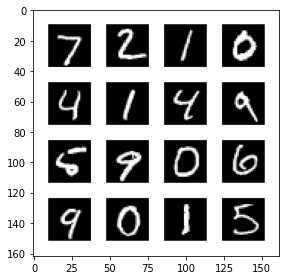

In [20]:
write_dir_single_MNIST = "./single_MNIST/"

transform = transforms.ToTensor()
mnist_trainset = torchvision.datasets.MNIST(write_dir_single_MNIST, train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(write_dir_single_MNIST, train=False, download=True, transform=transform)

# Visualize the single objects
show_batch(mnist_testset.data[:16].unsqueeze(1).float())

### Single-blobs dataset

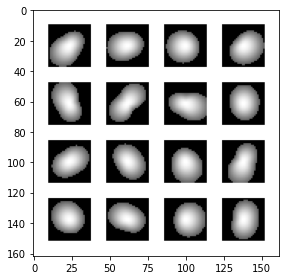

In [21]:
tmp_blobs_train = make_isolated_blobs(size=28,n_obj=2000)
tmp_blobs_test = make_isolated_blobs(size=28,n_obj=2000)
blobs_trainset = torch.utils.data.TensorDataset(*tmp_blobs_train)
blobs_testset = torch.utils.data.TensorDataset(*tmp_blobs_train)

# Visualize the single objects
show_batch(blobs_testset.tensors[0][:16].float())

### Create the multi-object dataset by pasting many single-object together

In [31]:
multimnist_trainset = create_dataset(params=default_params, 
                                     dataset_single_objects=mnist_trainset, 
                                     goal_for_class=100*torch.tensor([0,0,1,1]), 
                                     verbose=False)

multimnist_testset = create_dataset(params=default_params, 
                                    dataset_single_objects=mnist_trainset, 
                                    goal_for_class=100*torch.tensor([0,0,1,1]), 
                                    verbose=False)

multiblob_trainset = create_dataset(params=default_params, 
                                     dataset_single_objects=blobs_trainset, 
                                     goal_for_class=100*torch.tensor([0,0,1,1]), 
                                     verbose=False)

multiblob_testset = create_dataset(params=default_params, 
                                    dataset_single_objects=blobs_testset, 
                                    goal_for_class=100*torch.tensor([0,0,1,1]), 
                                    verbose=False)

Creating multi-object dataset
FINAL counter_for_class ----> tensor([  0,   0, 100, 100])


Creating multi-object dataset
FINAL counter_for_class ----> tensor([  0,   0, 100, 100])


Creating multi-object dataset
FINAL counter_for_class ----> tensor([  0,   0, 100, 100])


Creating multi-object dataset
FINAL counter_for_class ----> tensor([  0,   0, 100, 100])




### Add a structured background and save the datasets to file

In [36]:
def save_dataset_to_file(multi_instance_dataset, filename_base):
    data_imgs, data_seg, data_count = multi_instance_dataset
    grid = make_background_grid_discrete(params=default_params, n_obj=data_imgs.shape[0])
    data_imgs_with_grid = (data_imgs+grid).clamp(max=1.0)
    save_obj((data_imgs, data_seg, data_count), filename_base+"_nogrid.pt")
    save_obj((data_imgs_with_grid, data_seg, data_count), filename_base+"_withgrid.pt")
    print("created files -->", filename_base+"_nogrid.pt", filename_base+"_withgrid.pt")
    
save_dataset_to_file(multimnist_trainset, "./multimnist_80x80_n0_3_train")
save_dataset_to_file(multimnist_testset, "./multimnist_80x80_n0_3_test")
save_dataset_to_file(multiblob_trainset, "./multiblobs_80x80_n0_3_train")
save_dataset_to_file(multiblob_testset, "./multiblobs_80x80_n0_3_test")

created files --> ./multimnist_80x80_n0_3_train_nogrid.pt ./multimnist_80x80_n0_3_train_withgrid.pt
created files --> ./multimnist_80x80_n0_3_test_nogrid.pt ./multimnist_80x80_n0_3_test_withgrid.pt
created files --> ./multiblobs_80x80_n0_3_train_nogrid.pt ./multiblobs_80x80_n0_3_train_withgrid.pt
created files --> ./multiblobs_80x80_n0_3_test_nogrid.pt ./multiblobs_80x80_n0_3_test_withgrid.pt


### Check the MULTI-MNIST datasets

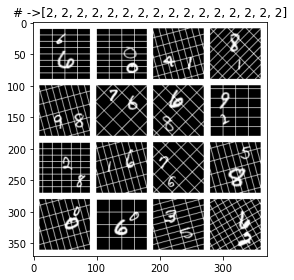

In [38]:
data_imgs, data_seg, data_count = load_obj("./multimnist_80x80_n0_3_test_withgrid.pt")
imgs_to_show = 16
n_instances = str(list(data_count[-imgs_to_show:].numpy()))
show_batch(data_imgs[-imgs_to_show:], title="# ->"+n_instances)

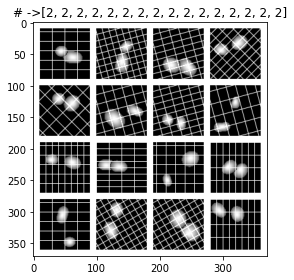

In [37]:
data_imgs, data_seg, data_count = load_obj("./multiblobs_80x80_n0_3_test_withgrid.pt")
imgs_to_show = 16
n_instances = str(list(data_count[-imgs_to_show:].numpy()))
show_batch(data_imgs[-imgs_to_show:], title="# ->"+n_instances)